# Music Genre Classification
Full Dataset from: https://github.com/mdeff/fma

In [4]:
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten, BatchNormalization, ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import numpy as np
from numpy import argmax
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11396345353559360787
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11154422528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4734268453153329894
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fma_small/'

Mounted at /content/gdrive


In [6]:
def genre_number(i):
    if i == 0:
        return 'Hip-Hop'
    elif i == 1:
        return 'Rock'
    

In [7]:
# Example of Hip-Hop music
y, sr = librosa.load(base_dir+'0/000002.mp3', duration=10)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
ps.shape

(128, 431)

In [8]:
IPython.display.Audio(data=y, rate=sr)

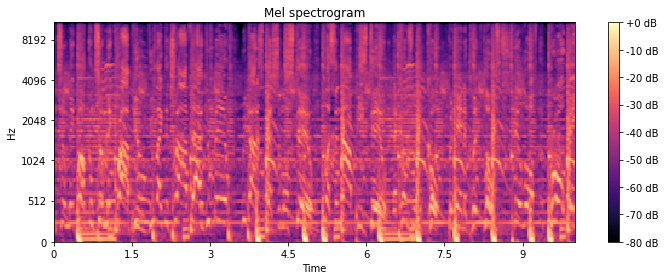

In [9]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [9]:
import os
print(os.listdir(base_dir+"0"))

['006609.mp3', '006443.mp3', '006442.mp3', '006606.mp3', '006610.mp3', '006439.mp3', '006603.mp3', '000002.mp3', '006607.mp3', '006608.mp3', '006611.mp3', '006440.mp3', '000005.mp3', '006605.mp3', '006448.mp3']


In [10]:
N_CLASSES = 2 # CHANGE HERE, total number of classes
D1 = [] # Dataset1
data = [] # Dataset1

for genre in range (0,N_CLASSES):
  for row in os.listdir(base_dir+"/"+str(genre)):
      y, sr = librosa.load(base_dir+'/'+str(genre)+"/" + row, duration=10)
      ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
      if ps.shape != (128, 431): continue
      D1.append( (ps, genre) )
      data.append(row)

In [11]:
print("Number of samples: ", len(D1))

Number of samples:  30


In [12]:
dataset = D1
random.shuffle(dataset)

#train dev test split 8:1:1
train = dataset[:20]
dev = dataset[20:25]
test = dataset[25:]

X_train, Y_train = zip(*train)
X_dev, Y_dev = zip(*dev)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 431, 1) ) for x in X_train])
X_dev = np.array([x.reshape( (128, 431, 1) ) for x in X_dev])
X_test = np.array([x.reshape( (128, 431, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 2))
Y_dev = np.array(keras.utils.to_categorical(Y_dev, 2))
Y_test = np.array(keras.utils.to_categorical(Y_test, 2))

In [13]:
model = Sequential()
input_shape=(128, 431, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 427, 24)      624       
_________________________________________________________________
average_pooling2d (AveragePo (None, 62, 213, 24)       0         
_________________________________________________________________
activation (Activation)      (None, 62, 213, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 213, 48)       28848     
_________________________________________________________________
average_pooling2d_1 (Average (None, 31, 106, 48)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 106, 48)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 106, 48)       5

In [15]:
epochs = 10
batch_size = 10
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [16]:
hist = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_dev, Y_dev)) 

Epoch 1/10
2/2 [==============================] - 31s 776ms/step - loss: 3.0634 - accuracy: 0.4333 - val_loss: 3.2154 - val_accuracy: 0.4000
Epoch 2/10
2/2 [==============================] - 0s 93ms/step - loss: 1.8619 - accuracy: 0.5333 - val_loss: 1.2235 - val_accuracy: 0.4000
Epoch 3/10
2/2 [==============================] - 0s 93ms/step - loss: 1.7524 - accuracy: 0.7000 - val_loss: 0.4154 - val_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 0s 92ms/step - loss: 0.7064 - accuracy: 0.6667 - val_loss: 0.6213 - val_accuracy: 0.4000
Epoch 5/10
2/2 [==============================] - 0s 89ms/step - loss: 0.4077 - accuracy: 0.7000 - val_loss: 0.6521 - val_accuracy: 0.4000
Epoch 6/10
2/2 [==============================] - 0s 94ms/step - loss: 0.3880 - accuracy: 0.7667 - val_loss: 0.5439 - val_accuracy: 0.4000
Epoch 7/10
2/2 [==============================] - 0s 96ms/step - loss: 0.3222 - accuracy: 0.9667 - val_loss: 0.4565 - val_accuracy: 0.8000
Epoch 8/10
2/2 [=========

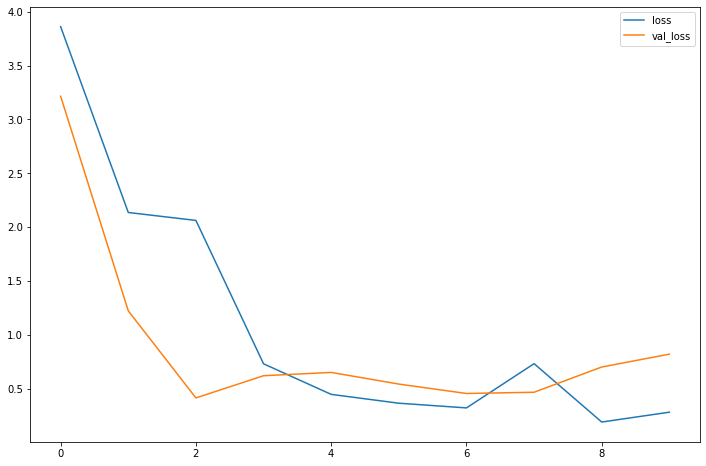

1/1 [==============================] - 0s 34ms/step - loss: 0.4240 - accuracy: 0.8000
Test loss: 0.4239521622657776
Test accuracy: 0.800000011920929


In [17]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.legend(['loss','val_loss'])
plt.show()

score = model.evaluate(x=X_test, y=Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [18]:
model.save('music_genre_classification.h5')

In [19]:
model = load_model('music_genre_classification.h5')

X, Y = zip(*D1)
X = np.array([x.reshape( (128, 431, 1) ) for x in X])
Y = np.array(keras.utils.to_categorical(Y, 2))

yhat = model.predict_classes(X)

#for i in range(len(D1)):
#    print('file_name: ' + data[i] + ' True: ' + genre_number(argmax(Y[i])) + ', Predict: ' + genre_number(yhat[i]))


for i in range(len(D1)):
    print('file_name: ' + data[i] + ' True: ' + str(argmax(Y[i])) + ', Predict: ' + str(yhat[i]))

file_name: 006609.mp3 True: 0, Predict: 0
file_name: 006443.mp3 True: 1, Predict: 1
file_name: 006442.mp3 True: 0, Predict: 0
file_name: 006606.mp3 True: 0, Predict: 0
file_name: 006610.mp3 True: 1, Predict: 1
file_name: 006439.mp3 True: 0, Predict: 1
file_name: 006603.mp3 True: 0, Predict: 0
file_name: 000002.mp3 True: 0, Predict: 0
file_name: 006607.mp3 True: 1, Predict: 1
file_name: 006608.mp3 True: 1, Predict: 1
file_name: 006611.mp3 True: 1, Predict: 1
file_name: 006440.mp3 True: 1, Predict: 1
file_name: 000005.mp3 True: 0, Predict: 1
file_name: 006605.mp3 True: 0, Predict: 0
file_name: 006448.mp3 True: 1, Predict: 1
file_name: 000574.mp3 True: 1, Predict: 1
file_name: 009557.mp3 True: 0, Predict: 0
file_name: 001039.mp3 True: 1, Predict: 1
file_name: 009513.mp3 True: 1, Predict: 1
file_name: 009553.mp3 True: 0, Predict: 1
file_name: 009559.mp3 True: 0, Predict: 0
file_name: 000777.mp3 True: 0, Predict: 1
file_name: 001087.mp3 True: 0, Predict: 1
file_name: 009550.mp3 True: 1, Pre

In [21]:
y, sr = librosa.load(base_dir+'1/001087.mp3', duration=10)
IPython.display.Audio(data=y, rate=sr)